【小白向】医学影像，多分类问题，学习记录

Reference/forked from:https://github.com/talhaanwarch/course

Data from:https://github.com/whiteBerryJ/Detect_covid19_from_CXR

https://cxr-covid19.grand-challenge.org/ 已过期

In [1]:
import numpy as np
from pytorch_lightning import seed_everything, LightningModule, Trainer
from sklearn.utils import class_weight
import torch.nn as nn
import torch
from torch.utils.data.dataloader import DataLoader
from pytorch_lightning.callbacks import EarlyStopping,ModelCheckpoint,LearningRateMonitor
from torch.optim.lr_scheduler import  ReduceLROnPlateau
import torchvision
from sklearn.metrics import classification_report,f1_score,accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
from PIL import Image
import cv2
from torch.utils.data import DataLoader, Dataset,ConcatDataset

### 定义数据增强 albumentation https://albumentations.ai/docs/api_reference/full_reference/

In [3]:
%%capture
!pip install -U albumentations

# ERROR: Could not install packages due to an OSError: [WinError 5]
# You need to run the command prompt or terminal as an administrator. 以管理员身份运行
# And also, you need to upgrade pip to the latest version - python -m pip install –-upgrade pip

In [4]:
# 使用魔法函数可以简单的实现一些单纯python要很麻烦才能实现的功能。
# 当我们想使用一个魔法命令，而不知怎么拼写函数名时，可以使用 %lsmagic来查询；
%lsmagic

Available line magics:
%alias  %alias_magic  %autoawait  %autocall  %automagic  %autosave  %bookmark  %cd  %clear  %cls  %colors  %conda  %config  %connect_info  %copy  %ddir  %debug  %dhist  %dirs  %doctest_mode  %echo  %ed  %edit  %env  %gui  %hist  %history  %killbgscripts  %ldir  %less  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %macro  %magic  %matplotlib  %mkdir  %more  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %pip  %popd  %pprint  %precision  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %ren  %rep  %rerun  %reset  %reset_selective  %rmdir  %run  %save  %sc  %set_env  %store  %sx  %system  %tb  %time  %timeit  %unalias  %unload_ext  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%SVG  %%bash  %%capture  %%cmd  %%debug  %%file  %%html  %%javascript  %%js  %%latex  %%markdown  %%perl  %%prun  %%pypy  %%python 

In [5]:
# 数据增强
# 用 albumentation(instead of torchvision)

import albumentations as A
from albumentations.pytorch import ToTensorV2


img_size=512
aug= A.Compose([
            A.Resize(img_size+32,img_size+32),
            A.RandomCrop(img_size,img_size),
            A.HorizontalFlip(0.5),
            A.VerticalFlip(0.5),
            A.ShiftScaleRotate(rotate_limit=3),
            A.Blur(),A.RandomGamma(),
            A.Sharpen(), A.GaussNoise(),
            A.CoarseDropout(8,64,64),
            A.CLAHE(0.5),
            A.Normalize(mean=(0), std=(1)),
            ToTensorV2(p=1.0),
        ], p=1.0)

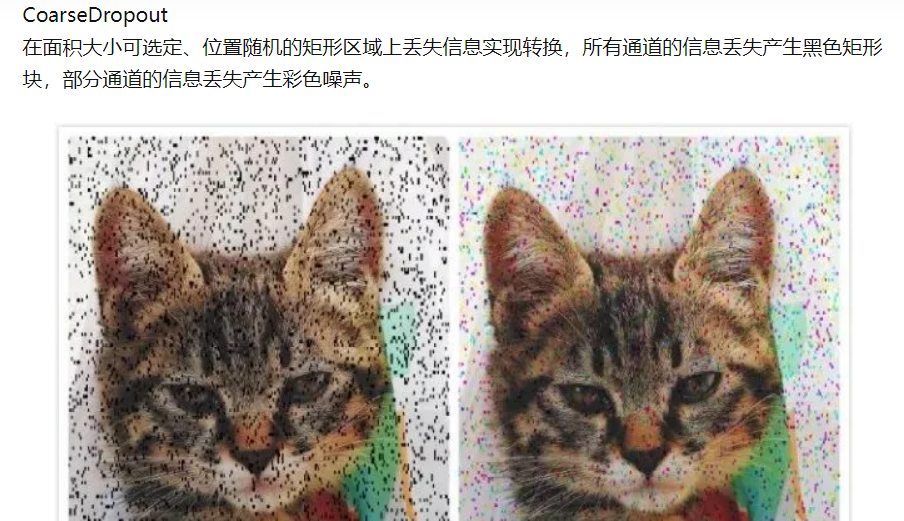

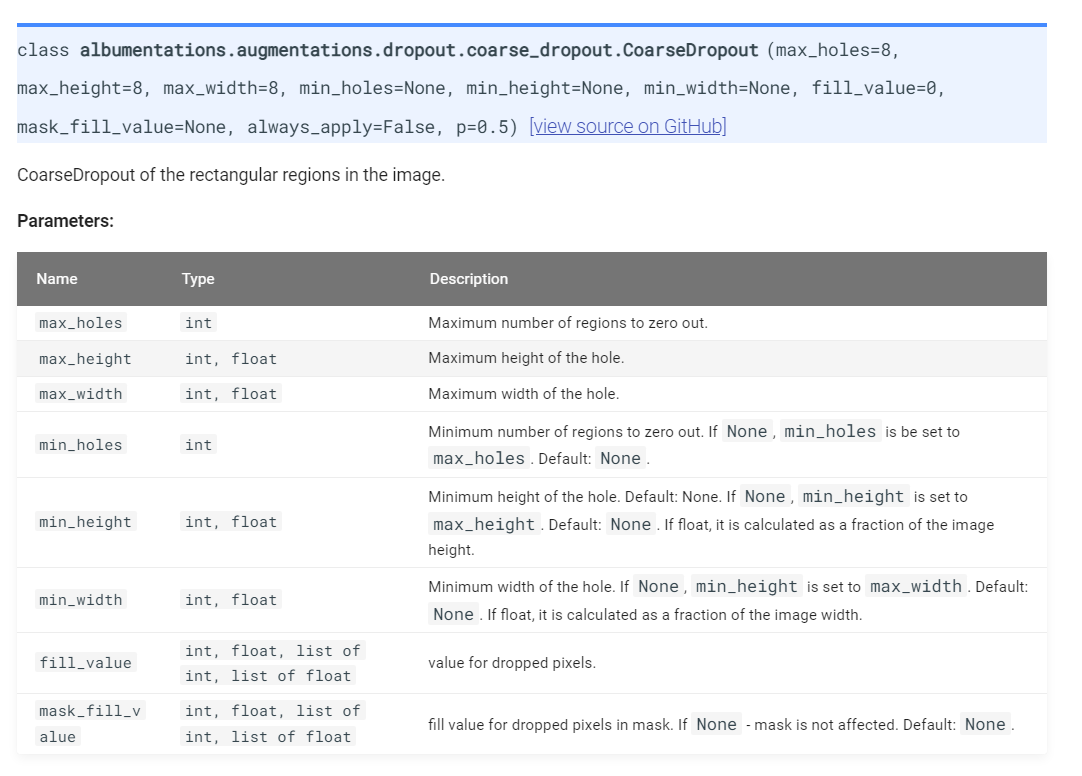

In [11]:
# 读取 train和 validation dataset
# read data from folders
class DataReader(Dataset):                        # inherited from Dataset
    def __init__(self, dataset, transform=None):  # constructor
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        x=self.dataset[index][0]   # iamge
        y=self.dataset[index][1]   # label
        if self.transform:         # 先不transform（transform=None），先转换成 np array（albumentation的要求）
            x=np.array(x)
            x=cv2.cvtColor(src=x, code=cv2.COLOR_RGB2GRAY) # to grayscal            
            x=self.transform(image=x)['image']  # 转换成tensor
        return x, y
    
    def __len__(self):
        return len(self.dataset)

In [12]:
# 读取 test dataset
# read data from dataframe                         ## DataFrame 是一个表格型的数据结构
class DFReader(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        x=self.dataset['case'][index]
        if self.transform:
            #x = self.transform(x)
            x=cv2.imread(x,0)
            x=np.array(x)
            #x=cv2.cvtColor(src=x, code=cv2.COLOR_RGB2GRAY)
            x=self.transform(image=x)['image']
        return x
    
    def __len__(self):
        return len(self.dataset)

## DataFrame https://www.runoob.com/pandas/pandas-dataframe.html


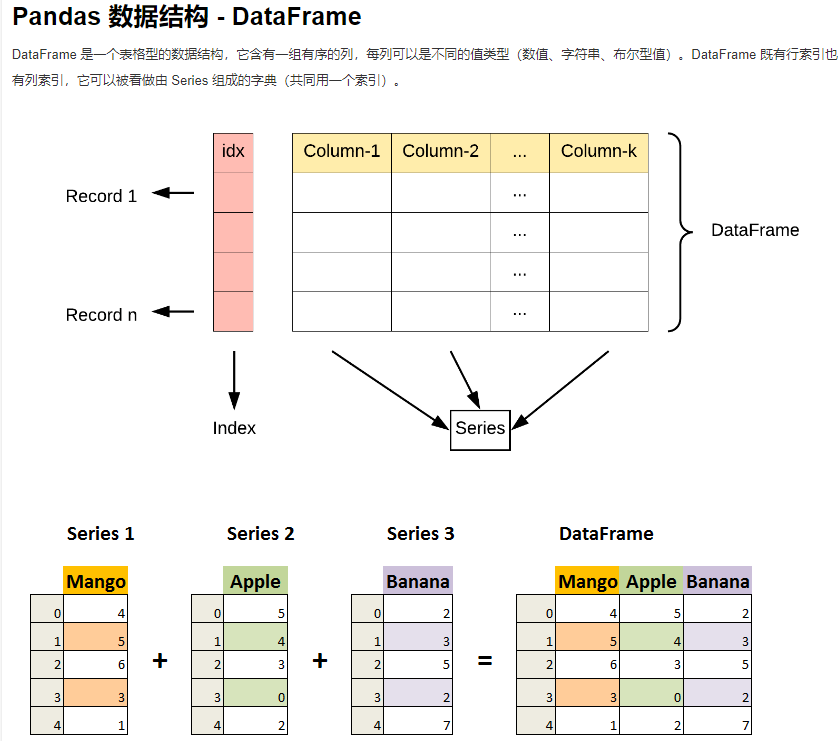

# testset 预处理

In [13]:
import os
testset_path = r'multiclass\test'
save_path = r'multiclass'
list = []
for i in os.listdir(testset_path):
    list.append(i)
    
# 查看list
list

['COVID-19 (19).png',
 'COVID-19 (20).png',
 'NORMAL (20).png',
 'NORMAL (19).png',
 'Viral Pneumonia (20).png',
 'Viral Pneumonia (19).png']

In [14]:
# pd.DataFrame(columns=name,data=list)
df = pd.DataFrame({'case': list,
                  'class': None,
                  })

In [15]:
print(df)

                       case class
0         COVID-19 (19).png  None
1         COVID-19 (20).png  None
2           NORMAL (20).png  None
3           NORMAL (19).png  None
4  Viral Pneumonia (20).png  None
5  Viral Pneumonia (19).png  None


In [17]:
df.to_csv('submission.csv')

In [ ]:
# 删除dataframe中的某些列 df.drop(['A','B'],axis=1)
df.drop(columns='Unnamed: 0')

In [18]:
test_df=pd.read_csv('submission.csv')  
print(test_df)

# 可以发现，多出了第一列，pandas自动加上了行号。
# 给read_csv加上这么个参数，index_col=0， 可去掉这列行号

   Unnamed: 0                      case  class
0           0         COVID-19 (19).png    NaN
1           1         COVID-19 (20).png    NaN
2           2           NORMAL (20).png    NaN
3           3           NORMAL (19).png    NaN
4           4  Viral Pneumonia (20).png    NaN
5           5  Viral Pneumonia (19).png    NaN


In [19]:
test_df=pd.read_csv('submission.csv',index_col=0)  # 
print(test_df)

                       case  class
0         COVID-19 (19).png    NaN
1         COVID-19 (20).png    NaN
2           NORMAL (20).png    NaN
3           NORMAL (19).png    NaN
4  Viral Pneumonia (20).png    NaN
5  Viral Pneumonia (19).png    NaN


In [ ]:
# [Errno 2] No such file or directory: '/submission.csv'
# test_df=pd.read_csv('/submission.csv') 

# 直接读文件，或者路径下的文件 
test_df=pd.read_csv('submission.csv')
test_df=pd.read_csv('./submission.csv')

In [20]:
test_df=pd.read_csv('./submission.csv',index_col=0) # 去掉行号列
test_df.case='./multiclass/test/'+test_df.case
print(test_df.head())
print('images in test data',len(test_df))

                                         case  class
0         ./multiclass/test/COVID-19 (19).png    NaN
1         ./multiclass/test/COVID-19 (20).png    NaN
2           ./multiclass/test/NORMAL (20).png    NaN
3           ./multiclass/test/NORMAL (19).png    NaN
4  ./multiclass/test/Viral Pneumonia (20).png    NaN
images in test data 6


In [21]:
# 总结
# 制作list存放test dataset的名字
import os
testset_path = r'multiclass\test'
save_path = r'multiclass'
list = []
for i in os.listdir(testset_path):
    list.append(i)
    
# 查看list
list

# 创建一个 pd.DataFrame，并写入一个csv
df = pd.DataFrame({'case': list,
                  'class': None,
                  })
df.to_csv('submission.csv')

# pd.read_csv
test_df=pd.read_csv('./submission.csv',index_col=0) # 去掉行号列
test_df.case='./multiclass/test/'+test_df.case
print(test_df.head())
print('images in test data',len(test_df))

                                         case  class
0         ./multiclass/test/COVID-19 (19).png    NaN
1         ./multiclass/test/COVID-19 (20).png    NaN
2           ./multiclass/test/NORMAL (20).png    NaN
3           ./multiclass/test/NORMAL (19).png    NaN
4  ./multiclass/test/Viral Pneumonia (20).png    NaN
images in test data 6


In [22]:
test_loader=DataLoader(DFReader(test_df,aug), batch_size =6)
test_batch=next(iter(test_loader))
test_batch.shape                 

torch.Size([6, 1, 512, 512])

In [23]:
type(test_batch)

torch.Tensor

In [24]:
train_split = torchvision.datasets.ImageFolder('./multiclass/train/')
dl=DataLoader(DataReader(train_split,aug),batch_size =45)
train_batch=next(iter(dl))
train_batch.shape  

AttributeError: 'list' object has no attribute 'shape'

In [26]:
type(train_batch)

list

In [25]:
print(train_batch)

[tensor([[[[0.2510, 0.2745, 0.2745,  ..., 0.4157, 0.4000, 0.3843],
          [0.2431, 0.2627, 0.2745,  ..., 0.4118, 0.3922, 0.3843],
          [0.2275, 0.2510, 0.2627,  ..., 0.4039, 0.3843, 0.3725],
          ...,
          [0.3255, 0.3255, 0.3176,  ..., 0.3255, 0.3451, 0.3176],
          [0.3373, 0.3255, 0.3255,  ..., 0.3255, 0.3647, 0.3686],
          [0.3373, 0.3373, 0.3294,  ..., 0.3373, 0.3882, 0.4000]]],


        [[[0.0980, 0.1647, 0.2039,  ..., 0.1686, 0.1255, 0.0510],
          [0.0902, 0.2157, 0.1882,  ..., 0.1804, 0.1255, 0.0431],
          [0.0667, 0.1843, 0.2314,  ..., 0.1843, 0.1333, 0.0549],
          ...,
          [0.3098, 0.3255, 0.2275,  ..., 0.6667, 0.6745, 0.6078],
          [0.2863, 0.3098, 0.2431,  ..., 0.6157, 0.6078, 0.6706],
          [0.2980, 0.2980, 0.2706,  ..., 0.3451, 0.3647, 0.5333]]],


        [[[0.8118, 0.7882, 0.8039,  ..., 0.0000, 0.0000, 0.0000],
          [0.8275, 0.7333, 0.7961,  ..., 0.0000, 0.0000, 0.0000],
          [0.8039, 0.8039, 0.7451,  .

# 模型构建

In [6]:
%%capture
!pip install timm
!pip install torchxrayvision

In [7]:
import timm
import torchmetrics
import torchvision.models as models
from torch.utils.data import random_split
import torchxrayvision as xrv  # 利用一下 weights="resnet50-res512-all"

torchxrayvision https://github.com/mlmed/torchxrayvision

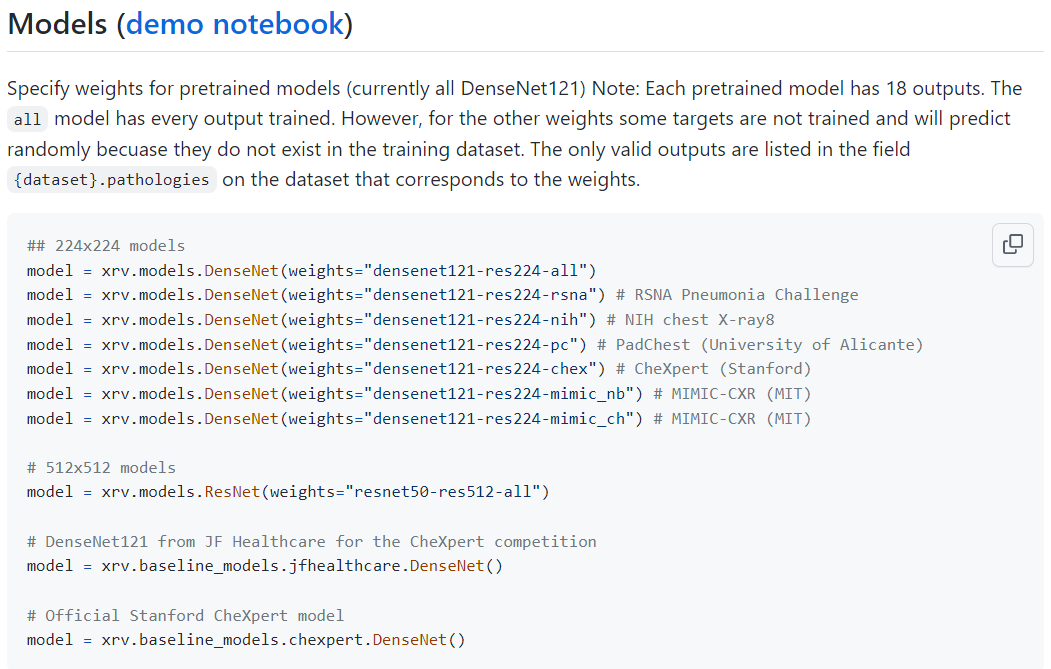

In [8]:
%%capture
! pip install torchxrayvision
import torchxrayvision as xrv

model = xrv.models.ResNet(weights="resnet50-res512-all")

In [9]:
model

XRV-ResNet-resnet50-res512-all

In [10]:
model.model

# (conv1): Conv2d(1, 64, ###) only accept grey scale image

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
class OurModel(LightningModule):
    def __init__(self,train_split,val_split):
        super(OurModel,self).__init__()
        # architecture
        self.model = xrv.models.ResNet(weights="resnet50-res512-all")
        self.model.model.fc = nn.Sequential(
            nn.Linear(2048,512),
            nn.ReLU(),
            nn.Linear(in_features=512,out_features=3)
        )
        self.model=self.model.model
        # parameters
        self.lr=1e-3
        self.batchsize=1
        self.numworkers=0
        
        # list to store accuracy and loss
        self.trainacc,self.trainloss=[],[]
        self.valacc,self.valloss=[],[]
        # loss
        self.criterion=nn.CrossEntropyLoss()
        # metric
        self.acc=torchmetrics.Accuracy(num_classes=3,task='multiclass')
        
        self.train_split=train_split
        self.val_split=val_split
        
    def forward(self,x):
        x = self.model(x)
        return x

    def configure_optimizers(self):
        opt = torch.optim.AdamW(params=self.parameters(),lr=self.lr)
        return opt

    def train_dataloader(self):
        dl=DataLoader(DataReader(self.train_split,aug),
                      shuffle=True,batch_size=self.batchsize,num_workers=self.numworkers)
        return dl

    def training_step(self,batch,bach_idx):
        image,label=batch
        pred=self(image)
        loss=self.criterion(pred,label)
        acc=self.acc(pred,label)
        return {'loss':loss,'acc':acc}

    def training_epoch_end(self, outputs):
        loss=torch.stack([x["loss"] for x in outputs]).mean().detach().cpu().numpy().round(2)##
        acc=torch.stack([x["acc"] for x in outputs]).mean().detach().cpu().numpy().round(2)##
        self.trainacc.append(acc)
        self.trainloss.append(loss)

    def val_dataloader(self):
        ds=DataLoader(DataReader(self.val_split,aug), 
                      batch_size = self.batchsize,
                      num_workers=self.numworkers,
                      #pin_memory=True, # for large dataset
                      #sampler=self.test_subsampler, 
                      shuffle=False)
        return ds

    def validation_step(self,batch,batch_idx):   ##### different from binary ###
        image,label=batch
        out=self(image)
        loss=self.criterion(out,label)
        acc=self.acc(out,label)
        return {'loss':loss,'acc':acc}

    def validation_epoch_end(self, outputs):
        loss=torch.stack([x["loss"] for x in outputs]).mean().detach().cpu().numpy().round(2)
        acc=torch.stack([x["acc"] for x in outputs]).mean().detach().cpu().numpy().round(2)
        self.valacc.append(acc)
        self.valloss.append(loss)
        print('validation loss accuracy ',self.current_epoch,loss, acc)  


In [ ]:
train_split = torchvision.datasets.ImageFolder('./multiclass/train/')
val_split = torchvision.datasets.ImageFolder('./multiclass/validation/')

In [ ]:
model=OurModel(train_split,val_split)

# 训练

In [ ]:
trainer=Trainer(#max_epochs=2,
                gpus=-1,
                precision=16,
                #limit_train_batches=5,
                #limit_val_batches=1
               )

In [ ]:
trainer.fit(model)

In [ ]:
# RuntimeError: expected scalar type Byte but found Float
# RuntimeError: Input type (torch.cuda.ByteTensor) and weight type (torch.cuda.FloatTensor) should be the same
images are uint8 (byte) while the neural network needs inputs as floating point in order to calculate gradients

In [ ]:
# test leaderboard

```
"Accuracy_score": 0.9358333333333333,
"Sensitivity_score": 0.9358333333333334,
"Specificity_score": 0.9382374634526824
```

# numworks error
PyTorch RuntimeError: DataLoader worker (pid(s) 15332) exited unexpectedly

https://download.csdn.net/download/weixin_38674992/14035463?ops_request_misc=%257B%2522request%255Fid%2522%253A%2522167382564316782428689830%2522%252C%2522scm%2522%253A%252220140713.130102334.pc%255Fall.%2522%257D&request_id=167382564316782428689830&biz_id=1&utm_medium=distribute.pc_search_result.none-task-download-2~all~first_rank_ecpm_v1~rank_v31_ecpm-1-14035463-null-null.142^v71^control,201^v4^add_ask&utm_term=RuntimeError%3A%20DataLoader%20worker%20%28pid%28s%29%2019332%29%20exited%20unexpectedly&spm=1018.2226.3001.4187.2
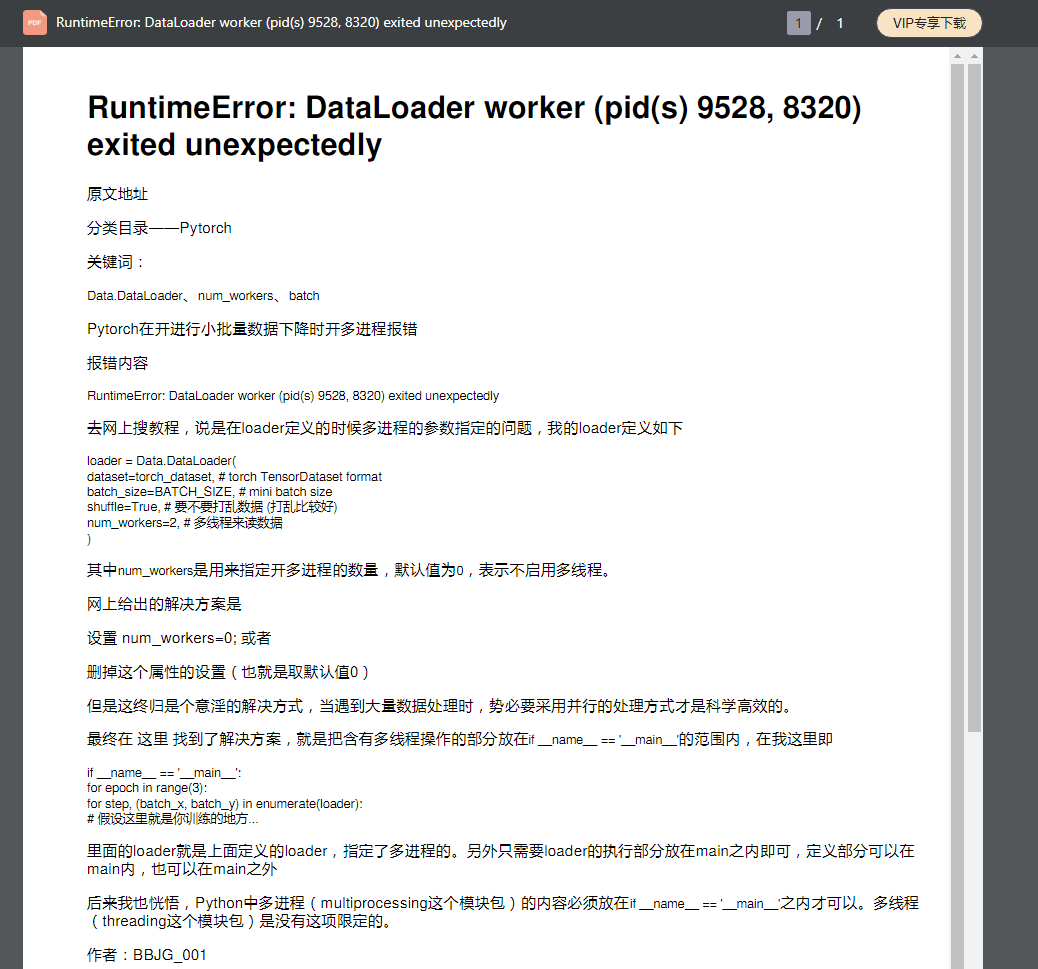

https://blog.csdn.net/VegetableofDog/article/details/124726339?ops_request_misc=%257B%2522request%255Fid%2522%253A%2522167382564316782428689830%2522%252C%2522scm%2522%253A%252220140713.130102334.pc%255Fall.%2522%257D&request_id=167382564316782428689830&biz_id=0&utm_medium=distribute.pc_search_result.none-task-blog-2~all~first_rank_ecpm_v1~rank_v31_ecpm-2-124726339-null-null.142^v71^control,201^v4^add_ask&utm_term=RuntimeError%3A%20DataLoader%20worker%20%28pid%28s%29%2019332%29%20exited%20unexpectedly&spm=1018.2226.3001.4187

